In [1]:
%cd bento

/home/jaemin/llm-cxr/bento


In [2]:
from typing import TYPE_CHECKING, cast
import PIL
import bentoml
from pydantic import BaseModel
from bentoml.io import JSON, Multipart, Text, NumpyNdarray, Image
import numpy as np
import os
import torch
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import PIL

if TYPE_CHECKING:
    from PIL.Image import Image


TARGET_IMAGE_SIZE = 256
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # for debugging purpose
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # for debugging purpose

llm_runner = bentoml.models.get("llm_cxr_qa:latest").to_runner()
vq_decoder_runner = bentoml.torchscript.get("vqmodel_decoder:latest").to_runner()
vq_encoder_runner = bentoml.torchscript.get("vqmodel_encoder:latest").to_runner()
svc = bentoml.Service(
    name="llm_cxr_qa", runners=[llm_runner, vq_decoder_runner, vq_encoder_runner]
)


# TextToText
class TextToTextRequestDTO(BaseModel):
    query: str

    class Config:
        extra = "forbid"
        arbitrary_types_allowed = True


class TextResponseDTO(BaseModel):
    answer: str

    class Config:
        extra = "forbid"
        arbitrary_types_allowed = True


@svc.api(
    input=JSON(pydantic_model=TextToTextRequestDTO),
    output=JSON(pydantic_model=TextResponseDTO),
)
async def t2t(dto: TextToTextRequestDTO) -> TextResponseDTO:
    out = await llm_runner.async_run((dto.query, None), max_new_tokens=512)
    answer = out[0]["generated_text"]
    return TextResponseDTO(
        answer=answer,
    )


# ImageToText
@svc.api(
    input=Multipart(query=Text(), img=Image()),
    output=JSON(pydantic_model=TextResponseDTO),
)
async def i2t(query: str, img: Image) -> TextResponseDTO:
    if not img.mode == "RGB":
        img = img.convert("RGB")
    s = min(img.size)

    if s < TARGET_IMAGE_SIZE:
        raise ValueError(f"min dim for image {s} < {TARGET_IMAGE_SIZE}")

    r = TARGET_IMAGE_SIZE / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [TARGET_IMAGE_SIZE])
    img = T.ToTensor()(img)
    # encode image
    image_indices = await vq_encoder_runner.async_run(img)
    out = await llm_runner.async_run((query, image_indices), max_new_tokens=512)
    answer = out[0]["generated_text"]
    return TextResponseDTO(
        answer=answer,
    )


# TextToImage
class TextToImageRequestDTO(BaseModel):
    instruction: str
    query: str

    class Config:
        extra = "forbid"
        arbitrary_types_allowed = True


@svc.api(input=JSON(pydantic_model=TextToImageRequestDTO), output=NumpyNdarray())
async def t2i(dto: TextToImageRequestDTO) -> np.ndarray:
    instruction = dto.instruction
    query = dto.query
    out = await llm_runner.async_run((instruction, query), max_new_tokens=512)
    generated_vq = cast(np.ndarray, out[0]["generated_vq"])
    img = await vq_decoder_runner.async_run(torch.tensor(generated_vq))
    return img


/home/jaemin/.pyenv/versions/3.10.13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
for runner in svc.runners:
    runner.init_local()

'Runner.init_local' is for debugging and testing only. Make sure to remove it before deploying to production.
'Runner.init_local' is for debugging and testing only. Make sure to remove it before deploying to production.
'Runner.init_local' is for debugging and testing only. Make sure to remove it before deploying to production.


In [4]:
img = PIL.Image.open("example.png")
inp = {
    "query": "Generate free-text radiology reports for the entered chest X-ray images.",
    "img": img, 
}
result3 = await svc.apis["i2t"].func(**inp)

/home/jaemin/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


Generate free-text radiology reports for the entered chest X-ray images. tensor([ 821,  226,  208,  640,  981, 1002,  640,  147,  640,  612,  447,  640,
         533,  329,  676,  988,  925,  640,  741,  358,  439,   71,  600,  921,
         202,  139,  742,  640,  213,  824,  741,  807,   26,  656,  167,  764,
         805,  406,  742,  741,  807,  551,  640,  640,   71,  139,  868,  789,
         824,  663,  139,  122,  339,  336,  258,  612,  193,  551,  640,  122,
         333,  764,  428,  921,  634,  921,  481,  187,  961,  981,  182,  345,
         167,   63,  542, 1012,  200,  213,  616,  580,  640,  226,   32,  593,
         551,  548,  213,  621,  640,  742,  250,  961,  612,  471,  333,  680,
         336,  672,  139,  916,   82,   71,  640,  468,  202,  807,  580,  459,
         139,  336,  529,  680,  468,  921,  640,  920,  529,  640, 1002,  467,
         529,  551,  612,  139,  533,  897,  225,  147,  260,  171,  676,  910,
         243,  640,  468,  634,  990,  248,  74

In [5]:
result3

TextResponseDTO(answer='Right upper lobe pneumonia.  Recommend followup to resolution.')

In [6]:
inp = {"query":"Does MRI pose a risk of radiation exposure? Please write as long as you can."}
result1 = await svc.apis["t2t"].func(TextToTextRequestDTO(**inp))

In [7]:
result1

TextResponseDTO(answer='No, MRI does not generate any type of radiation and does not pose a risk of radiation exposure.')

In [8]:
inp = {
    "instruction":"Generate a chest X-ray image that corresponds to the entered free-text radiology reports for the chest X-ray image.",
	"query": "A new dual-lead pacemaker with lead positioned through the left transvenous approach end into the right ventricle and is appropriate. No focal lung opacities concerning for pneumonia.  Heart is top normal size. Mediastinal and hilar contours are normal.  No evidence of pneumothorax."
}
result2 = await svc.apis["t2i"].func(TextToImageRequestDTO(**inp))

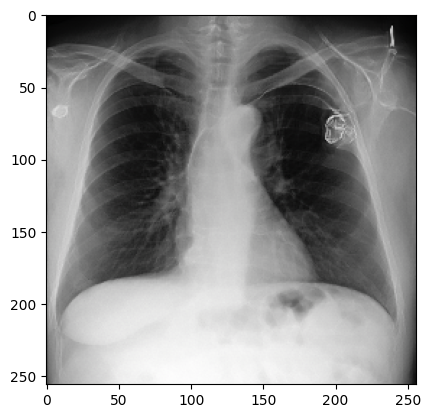

In [9]:
import matplotlib.pyplot as plt
plt.imshow(result2.cpu().numpy())